# Perform simulation-based inference

In this notebook, we load the saved $\mathrm{CNN}_{3\mathrm{D}}$ predictions and ground truth from test set, then estimate the joint distribution of parameter (dynamical mass, $M$) and neural network summaries ($\tilde{d}$) using a 2D Gaussian KDE and then perform simulation-based inference (hereafter, SBI) to infer the cluster masses in the evaluation set. Note that the $\mathrm{CNN}_{3\mathrm{D}}$ model was trained using a separate training set. We construct and train the model in `train.py`, and also obtain all predictions for all clusters in the test and evaluation sets.

### Import relevant packages

In [1]:
%pylab inline
import numpy as np
import tqdm
import scipy as sp
import scipy.constants as spc
from scipy.interpolate import interp1d
from scipy.signal import medfilt
from scipy.stats import norm
from matplotlib import rc
rc('text', usetex=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tools import *

Populating the interactive namespace from numpy and matplotlib


### Load predictions for test set

In [2]:
saved_predictions = np.load("predictions/BNN_3D_predictions_test_h0_175_final_transform_4Mpc.npz")

M200c_true = saved_predictions["ground_truth"]
M200c_pred = saved_predictions["prediction"]

### Compute 2D KDE representation of the joint distribution, $\mathcal{P}(M|\tilde{d})$

Note that here, we choose our network summaries to conveniently correspond to the network point mass predictions. This is motivated by the fact that a neural network, by design, performs feature extraction to yield meaningful summaries. See our paper for more details.

In [3]:
predictions_ = np.stack([M200c_pred, M200c_true], axis=0)

# Specify a bandwidth scaling
bandwidth = 0.20
kde_pred = sp.stats.gaussian_kde(predictions_, bandwidth)

# Size of mesh grid
Nbins = 1000

# Range of masses
M_true_ = np.linspace(13.25, 15.5, Nbins)
M_pred_ = np.linspace(13.25, 15.5, Nbins)

# Build the grid
pred_grid = np.meshgrid(M_true_, M_pred_, indexing='ij')
pred_grid = (np.array(pred_grid).reshape(2,-1))

# Evaluate the 2D KDE on the grid
pred_density = kde_pred.evaluate(pred_grid)
pred_density = pred_density.reshape(Nbins,Nbins)

# Normalize KDE
pred_density /= np.sum(pred_density)

### Plot the estimated joint 2D distribution of parameter ($M$) and network summaries ($\tilde{d}$)

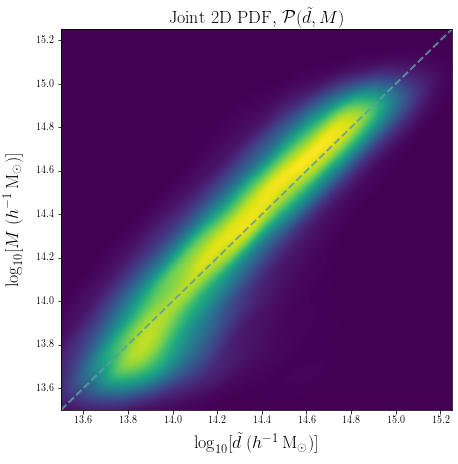

In [4]:
test_x, test_y = np.meshgrid(M_pred_, M_true_, indexing='ij')

fig, ax = plt.subplots(1, figsize=(7,7))

ax.scatter(test_x.flatten(), test_y.flatten(), s=100, c=pred_density.flatten(), cmap="viridis", rasterized=True);

ax.plot([13.5, 15.5], [13.5, 15.5], linewidth=2, linestyle='--', color='cadetblue', alpha=0.85) #, label=r'$\mathrm{ground \ truth}$')
xlabel(r'$\log_{10}[\tilde{d} \; (h^{-1} \, \mathrm{M}_{\odot})]$', fontsize=18, labelpad=10);
ylabel(r'$\log_{10}[M \; (h^{-1} \, \mathrm{M}_{\odot})]$', fontsize=18, labelpad=10);

ax.set_title(r'$\mathrm{Joint \ 2D \ PDF,} \; \mathcal{P}(\tilde{d}, M)$', fontsize=18);

ax.set_aspect("auto")
ax.set_xlim(13.5,15.25);
ax.set_ylim(13.5,15.25);

### Slicing the joint distribution

Since the KDE is a 2D array, the following steps are simply to know where to slice.
`pred_ID` indexes a particular cluster in the saved predictions. Let's do this for a particular cluster.

In [8]:
delta_M = (15.5 - 13.25)/Nbins

# Pick an index of a given cluster
pred_ID = int(500)

# Slice through KDE
slice_ID = int(np.floor((M200c_pred[pred_ID] - 13.25)/delta_M))

### Plot the posterior distribution for the above galaxy cluster

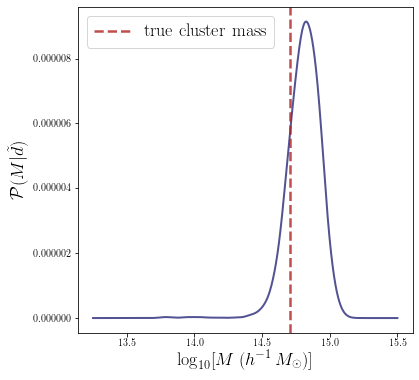

In [11]:
fig, ax = plt.subplots(1, figsize=(6,6))

plot(M_true_, pred_density[slice_ID,:], linewidth = 2, color="MidnightBlue", alpha=0.75);

axvline(x=M200c_true[pred_ID], linewidth=2.5, linestyle='--', label=r'$\mathrm{true \ cluster \ mass}$', color='firebrick', alpha=0.8);
xlabel(r'$\log_{10}[M \; (h^{-1} \, M_{\odot})]$', fontsize=18, labelpad=5);
ylabel(r'$\mathcal{P}(M | \tilde{d})$', fontsize=18, labelpad=5);
legend(fontsize=18);

### Repeat the above for all clusters in the evaluation set

Reminder: The evaluation set is a separate set of clusters unseen by the network. The purpose of the evaluation set is to assess the performance of the dynamical mass estimator.

### Load evaluation set

In [12]:
saved_predictions = np.load("predictions/BNN_3D_predictions_validation_h0_175_final_transform_4Mpc.npz")

M200c_true = saved_predictions["ground_truth"]
M200c_pred = saved_predictions["prediction"]

### Loop through all clusters in the evaluation set

In [13]:
PDF_SBI = []

for pred_ID in tqdm.tqdm(range(M200c_true.size)):
    
    slice_ID = int(np.floor((M200c_pred[pred_ID] - 13.25)/delta_M))
    PDF_SBI.append(pred_density[slice_ID,:])
    
print(np.array(PDF_SBI).shape)

100%|██████████| 4996/4996 [00:00<00:00, 294680.67it/s]


### Estimate asymmetric 1$\sigma$ from above PDFs

There is a useful function (`compute_PDF_sigma`) to infer the 1$\sigma$ lower and upper limits for arbitrary PDFs in `tools.py`.

In [17]:
numPDFs = M200c_true.size

pred_sigma_lower = []
pred_sigma_upper = []
peak_PDF = []

for m in tqdm.tqdm(range(numPDFs)):
    peak, sigma_lower, sigma_upper = compute_PDF_sigma(PDF_SBI[m], M_true_)
    pred_sigma_lower.append(sigma_lower)
    pred_sigma_upper.append(sigma_upper)
    peak_PDF.append(peak)

100%|██████████| 4996/4996 [00:01<00:00, 3822.15it/s]


### Compute PDF summary statistics

The function below computes the relevant quantities per mass bin to produce the main performance plot.

In [18]:
def compute_PDF_summary(M_true, M_pred_mean, M_pred_sigma_lower, M_pred_sigma_upper, Nbins):
    
    av_true = []
    av_mean = []
    av_sigma_lower = []
    av_sigma_upper = []
    pred_std = []
    av_epsilon = []
    av_abs_epsilon = []
    std_epsilon = []

    bins = np.logspace(13.6, 15.05, num=Nbins, endpoint=True, base=10.0) #15.25
    bins = np.log10(bins)
    Mbins_c = 0.5*(bins[0:bins.size-1] + bins[1:])
    
    for k in tqdm.tqdm(range(bins.size - 1)):
        temp_true = []
        temp_mean = []
        temp_sigma_lower = []
        temp_sigma_upper = []
        temp_epsilon = []
        temp_abs_epsilon = []
        for i in range(M_true.size):
            if M_true[i] >= bins[k] and M_true[i] <= bins[k+1]:
                temp_true.append(M_true[i])
                temp_mean.append(M_pred_mean[i])
                temp_sigma_lower.append(M_pred_sigma_lower[i])
                temp_sigma_upper.append(M_pred_sigma_upper[i])
                temp_epsilon.append(M_pred_mean[i] - M_true[i])
                temp_abs_epsilon.append(np.abs(M_pred_mean[i] - M_true[i]))
        av_true.append(np.average(temp_true))
        av_mean.append(np.average(temp_mean))
        av_sigma_lower.append(np.average(temp_sigma_lower))
        av_sigma_upper.append(np.average(temp_sigma_upper))
        pred_std.append(np.std(temp_mean))
        av_epsilon.append(np.average(temp_epsilon))
        av_abs_epsilon.append(np.average(temp_abs_epsilon))
        std_epsilon.append(np.std(temp_epsilon))
    
    return av_true, av_mean, av_sigma_lower, av_sigma_upper, pred_std, av_epsilon, av_abs_epsilon, std_epsilon, Mbins_c

In [19]:
av_true, av_pred_mean, av_pred_sigma_lower, av_pred_sigma_upper, pred_std, av_epsilon, av_abs_epsilon, std_epsilon, Mbins_c = compute_PDF_summary(M200c_true, M200c_pred, pred_sigma_lower, pred_sigma_upper, Nbins=23)

100%|██████████| 22/22 [00:00<00:00, 286.95it/s]


### Visualize predictive performance of $\mathrm{CNN}_{3\mathrm{D}}$ mass estimator

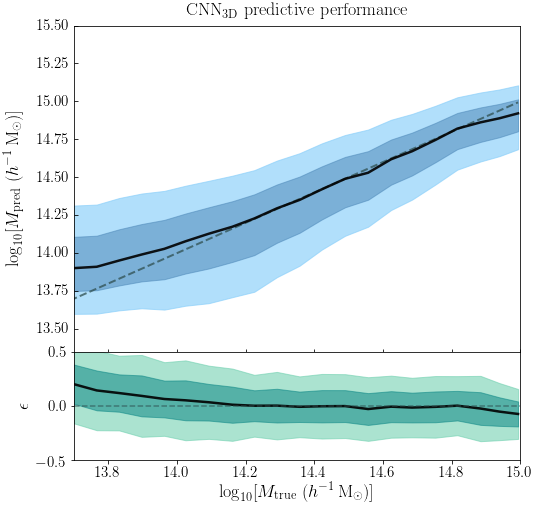

In [24]:
import matplotlib.gridspec as gridspec

fig, ax = subplots(2, 1, figsize = (8,8), sharex=True, sharey=False, gridspec_kw={'height_ratios': [3,1]})
subplots_adjust(wspace = 0, hspace = 0)

ax[0].plot(av_true, av_true, linewidth=2, linestyle='--', color='darkslategray', alpha=0.75)
ax[0].fill_between(av_true, np.array(av_pred_mean) - 2*np.array(av_pred_sigma_lower), np.array(av_pred_mean) + 2*np.array(av_pred_sigma_upper), color='lightskyblue', alpha=0.65)
ax[0].fill_between(av_true, np.array(av_pred_mean) - np.array(av_pred_sigma_lower), np.array(av_pred_mean) + np.array(av_pred_sigma_upper), color='steelblue', alpha=0.50)

ax[0].plot(av_true, av_pred_mean, linestyle='-', lw=2.5, color='black', alpha=0.90, label=r'$\langle \mu \rangle_{m}$')

ax[0].axhline(y=0, xmin=0, xmax=0, linewidth=10, linestyle='-', color='steelblue', alpha=0.60, label=r'$\langle 1\sigma \rangle_{m}$')
ax[0].axhline(y=0, xmin=0, xmax=0, linewidth=10, linestyle='-', color='lightskyblue', alpha=0.75, label=r'$\langle 2\sigma \rangle_{m}$')

ax[0].set_xlim(av_true[1], av_true[-1]);
ax[0].set_ylim(13.35, 15.5);

ax[0].set_ylabel(r'$\log_{10}[M_{\mathrm{pred}} \; (h^{-1} \, \mathrm{M}_{\odot})]$', fontsize=18, labelpad=10);
ax[0].tick_params(axis='both', direction='in', labelbottom=False, labelsize=15);
ax[0].set_title(r'$\mathrm{CNN_{3D} \ predictive \ performance}$', fontsize=18);

ax[1].plot(av_true, av_epsilon, linestyle='-', lw=2.5, color='black', alpha=0.90, label=r'$\langle \epsilon \rangle_{m}$')
ax[1].fill_between(av_true, av_epsilon-2*np.array(std_epsilon), av_epsilon+2*np.array(std_epsilon), color='mediumaquamarine', alpha=0.55)
ax[1].fill_between(av_true, av_epsilon-np.array(std_epsilon), av_epsilon+np.array(std_epsilon), color='teal', alpha=0.5)
ax[1].axhline(y=0., linewidth=1.5, linestyle='--', color='darkslategrey', alpha=0.6)

ax[1].set_ylim(-0.5, 0.5);
ax[1].set_xlim(av_true[1], 15.0);

ax[1].set_ylabel(r'$\epsilon$', fontsize=18, labelpad=5);
ax[1].set_xlabel(r'$\log_{10}[M_{\mathrm{true}} \; (h^{-1} \, \mathrm{M}_{\odot})]$', fontsize=18, labelpad=5);
ax[1].tick_params(axis='both', labelsize=15);

# Repeat the above procedure to infer the dynamical masses of SDSS clusters

### SDSS-III literature values

In [25]:
literature_estimates = np.load("predictions/SDSS_abdullah_et_al_2019_results_4Mpc.npz")
M200c_lit = literature_estimates["M200c_list"]
M200c_error_lit = literature_estimates["M200c_error_list"]

### SDSS-III cluster mass point predictions from $\mathrm{CNN}_{3\mathrm{D}}$

In [26]:
saved_predictions = np.load("predictions/BNN_3D_predictions_SDSS_final_transform_4Mpc.npz")
M200c_pred_SDSS = saved_predictions["prediction"]

### Infer uncertainties using SBI

In [27]:
numPDFs_SDSS = M200c_pred_SDSS.size
PDF_SBI_SDSS = []

for pred_ID in tqdm.tqdm(range(M200c_pred_SDSS.size)):
    
    slice_ID = int(np.floor((M200c_pred_SDSS[pred_ID] - 13.25)/delta_M))
    PDF_SBI_SDSS.append(pred_density[slice_ID,:])

100%|██████████| 909/909 [00:00<00:00, 109262.98it/s]


### Estimate asymmetric 1$\sigma$ from above PDFs

In [29]:
pred_sigma_lower_SDSS = []
pred_sigma_upper_SDSS = []

for m in tqdm.tqdm(range(numPDFs_SDSS)):
    peak, sigma_lower, sigma_upper = compute_PDF_sigma(PDF_SBI_SDSS[m], M_true_)
    pred_sigma_lower_SDSS.append(sigma_lower)
    pred_sigma_upper_SDSS.append(sigma_upper)

100%|██████████| 909/909 [00:00<00:00, 3753.24it/s]


### Plot our predictions against those of Abdulla+ (2019)

Note that we need to first filter out clusters which lie close to the edge of the SDSS footprint. See our paper for more details.

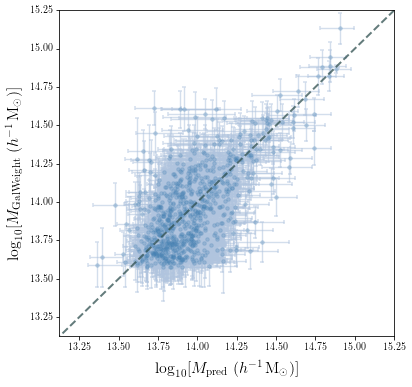

In [10]:
figure(figsize = (6,6))

M_ref = np.arange(13, 16, 0.1)

plot(M_ref, M_ref, linewidth=2, linestyle='--', color='darkslategray', alpha=0.75)

for i in range(len(M200c_lit)):
    hlines(y=M200c_lit[i], xmin=M200c_pred_SDSS[i]-pred_sigma_lower_SDSS[i], xmax=M200c_pred_SDSS[i]+pred_sigma_upper_SDSS[i], linewidth=1.4, linestyle='-', color='lightsteelblue', alpha=0.55, zorder=1)
    scatter(M200c_pred_SDSS[i]-pred_sigma_lower_SDSS[i], M200c_lit[i], marker='|', s=10, color='lightsteelblue', alpha=0.55, zorder=1)
    scatter(M200c_pred_SDSS[i]+pred_sigma_upper_SDSS[i], M200c_lit[i], marker='|', s=10, color='lightsteelblue', alpha=0.55, zorder=1)

for i in range(len(M200c_lit)):
    vlines(x=M200c_pred_SDSS[i], ymin=M200c_lit[i]-M200c_error_lit[i], ymax=M200c_lit[i]+M200c_error_lit[i], linewidth=1.4, linestyle='-', color='lightsteelblue', alpha=0.55, zorder=1)
    scatter(M200c_pred_SDSS[i], M200c_lit[i]-M200c_error_lit[i], marker='_', s=10, color='lightsteelblue', alpha=0.55, zorder=1)
    scatter(M200c_pred_SDSS[i], M200c_lit[i]+M200c_error_lit[i], marker='_', s=10, color='lightsteelblue', alpha=0.55, zorder=1)

scatter(M200c_pred_SDSS, M200c_lit, marker='.', s=50, color='steelblue', alpha=0.25)

xlim(13.125, 15.25);
ylim(13.125, 15.25);

xlabel(r'$\log_{10}[M_{\mathrm{pred}} \; (h^{-1} \, \mathrm{M}_{\odot})]$', fontsize=16, labelpad=10);
ylabel(r'$\log_{10}[M_{\mathrm{GalWeight}} \; (h^{-1} \, \mathrm{M}_{\odot})]$', fontsize=16, labelpad=5);

### Compute 1D PDF of mass contrast

In [13]:
mass_contrast_list = []

for i in range(NewNumClusters):
    sigma_sum_squares = np.sqrt( (0.5*(pred_sigma_upper_SDSS[i] + pred_sigma_lower_SDSS[i]))**2 + M200c_error_lit[i]**2 )
    mass_contrast_list.append((M200c_pred_SDSS[i] - M200c_lit[i])/sigma_sum_squares)

### Check mean and sigma of this 1D PDF

In [14]:
print(np.average(mass_contrast_list))
print(np.std(mass_contrast_list))

0.012582620979586723
0.9304582447265205


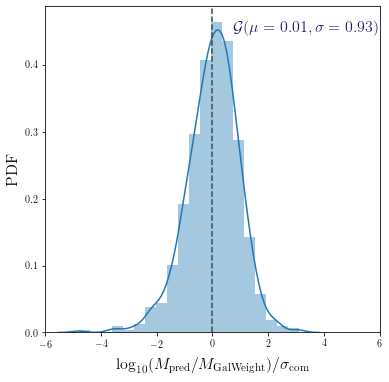

In [27]:
figure(figsize = (6,6))

sns.distplot(mass_contrast_list, bins=20); # kde='False'
axvline(x=0, linewidth=1.5, linestyle='--', color='darkslategray', alpha=1.0);
text(0.75, 0.45, r'$\mathcal{G}(\mu= 0.01, \sigma=0.93)$', fontsize=16, color="MidnightBlue");
xlim(-6, 6);
ylabel(r'$\mathrm{PDF}$', fontsize=16);
xlabel(r'$\log_{10} (M_{\mathrm{pred}} / M_{\mathrm{GalWeight}}) / \sigma_{\mathrm{com}}$', fontsize=16, labelpad=10);